Enter the company name (e.g., NVIDIA):  TSLA


[*********************100%***********************]  1 of 1 completed


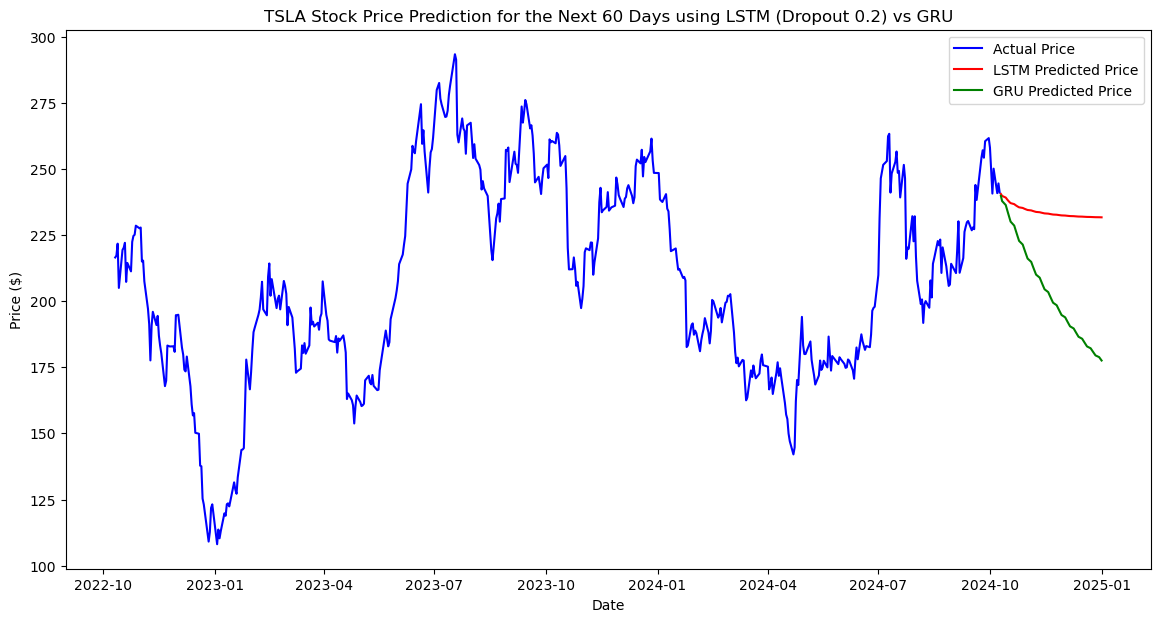

(            LSTM Predicted Price
 2024-10-10            240.506607
 2024-10-11            239.776550
 2024-10-14            239.153412
 2024-10-15            238.544861
 2024-10-16            237.991043
 2024-10-17            237.496323
 2024-10-18            237.055756
 2024-10-21            236.663452
 2024-10-22            236.313354
 2024-10-23            235.999603
 2024-10-24            235.716888
 2024-10-25            235.460495
 2024-10-28            235.226349
 2024-10-29            235.011139
 2024-10-30            234.812042
 2024-10-31            234.626816
 2024-11-01            234.453598
 2024-11-04            234.290924
 2024-11-05            234.137604
 2024-11-06            233.992722
 2024-11-07            233.855499
 2024-11-08            233.725372
 2024-11-11            233.601791
 2024-11-12            233.484406
 2024-11-13            233.372879
 2024-11-14            233.266891
 2024-11-15            233.166229
 2024-11-18            233.070633
 2024-11-19   

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Input
from datetime import datetime, timedelta

# 1. 데이터 수집 및 전처리 (공통)
start = (datetime.now() - timedelta(days=730)).strftime('%Y-%m-%d')
end = datetime.now().strftime('%Y-%m-%d')
company_name = input("Enter the company name (e.g., NVIDIA): ")
ticker = yf.Ticker(company_name).info['symbol']  # 회사명으로 티커 찾기
df = yf.download(ticker, start=start, end=end)  # 주식 데이터 다운로드

data = df['Close'].values.reshape(-1, 1)  # 종가 데이터를 2D 배열로 변형
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터 정규화
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=60):
    X = []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
    return np.array(X)

time_step = 60
X_train = create_dataset(scaled_data, time_step)

# 데이터 형식 변환 (3D 배열)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# 2. LSTM 모델 구축 및 훈련
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# LSTM 모델 훈련
lstm_model.fit(X_train, scaled_data[time_step:], epochs=300, batch_size=32, verbose=0)

# 3. GRU 모델 구축 및 훈련
gru_model = Sequential()
gru_model.add(Input(shape=(X_train.shape[1], 1)))
gru_model.add(GRU(units=50, return_sequences=True))
gru_model.add(Dropout(0.35))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dropout(0.35))
gru_model.add(Dense(units=1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# GRU 모델 훈련
gru_model.fit(X_train, scaled_data[time_step:], epochs=300, batch_size=32, verbose=0)

# 4. 미래 60일 예측 함수
def predict_future(model, data, days_to_predict=60, time_step=60):
    future_predictions = []
    last_sequence = data[-time_step:].reshape(1, time_step, 1)  # 가장 최근 60일 데이터를 준비
    
    for _ in range(days_to_predict):
        predicted_price_scaled = model.predict(last_sequence, verbose=0)  # 예측 수행
        future_predictions.append(predicted_price_scaled[0, 0])  # 예측된 값 저장
        last_sequence = np.append(last_sequence[:, 1:, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)  # 새로운 시퀀스 업데이트
    
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))  # 원래 스케일로 변환

# 5. 미래 60일 예측 수행
future_days = 60
lstm_future_predictions = predict_future(lstm_model, scaled_data, days_to_predict=future_days)
gru_future_predictions = predict_future(gru_model, scaled_data, days_to_predict=future_days)

# 6. 미래 예측 날짜 생성
future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=future_days, freq='B')

# 7. 시각화
plt.figure(figsize=(14, 7))

# 실제 주가
plt.plot(df.index, data, color='blue', label='Actual Price')

# LSTM 예측 결과
plt.plot(future_dates, lstm_future_predictions, color='red', label='LSTM Predicted Price')

# GRU 예측 결과
plt.plot(future_dates, gru_future_predictions, color='green', label='GRU Predicted Price')

plt.title(f'{ticker} Stock Price Prediction for the Next 60 Days using LSTM (Dropout 0.2) vs GRU')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 8. 예상 주가 출력
lstm_predicted_df = pd.DataFrame(lstm_future_predictions, index=future_dates, columns=['LSTM Predicted Price'])
gru_predicted_df = pd.DataFrame(gru_future_predictions, index=future_dates, columns=['GRU Predicted Price'])

# LSTM 및 GRU 예측 결과 출력
lstm_predicted_df, gru_predicted_df
